In [ ]:
#tools
import pandas as pd
import numpy as np
import json

#Machine Learning
from sklearn.ensemble import RandomForestRegressor
from fbprophet import Prophet

#Plot and display
from IPython.display import display, HTML
from plotnine import *


## EDA

  this section I just want to take a look at the data format and try to create some insights

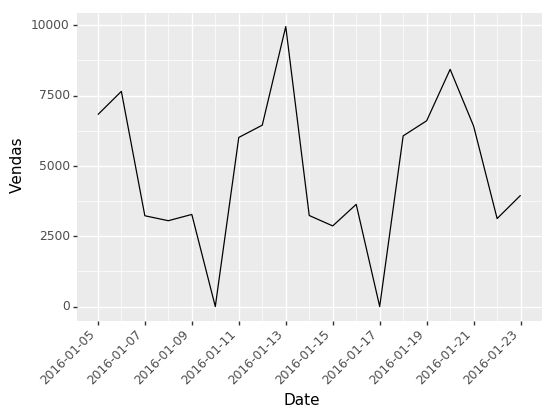

<ggplot: (8742071146845)>

In [8]:
#Read the full data
all_data = json.load(open('sample.txt'))
#preparing the initial dataframe
df = pd.DataFrame()
for elem in all_data:
    elem_value = elem['complemento']['valorTotal']
    elem_date = elem['ide']['dhEmi']['$date']
    df_elem = pd.DataFrame([[elem_date, elem_value]], columns=['ds', 'y'])
    df = df.append(df_elem)

#converting date column to datetime 
df['ds'] = pd.to_datetime(df['ds'])

#Resampling to day scale
df_day = df.resample('D', on='ds').sum().reset_index()

#Plotting the initial data
ggplot(df_day,aes('ds','y'))\
    + geom_line()\
    + labs(y="Vendas", x = "Date")\
    + theme(axis_text_x = element_text(angle = 45, hjust = 1))

Here we can see some interesting pattern, althoug it's composed by small data we already can see that the store does not work on Sundays and has its sales peaks on Wednesdays. That already says a lot about the profile of the s, where we can already exclude places like pubs, clubs, bars etc that usually present higher profits as the days approach the weekend. If I were to give a guess I would say that this profile looks like a classic business restaurant

In [27]:
df_sells = pd.DataFrame()
for elem in all_data:
    for products in elem['dets']:
        prod_name = products['prod']['xProd']
        prod_value = products['prod']['vProd']
        df_prods = pd.DataFrame([[prod_name, prod_value]], columns=['Product', 'value'])
        df_sells = df_sells.append(df_prods)

In [54]:
df_sells_group = df_sells.groupby(['Product']).sum().reset_index().sort_values(by=['value'])

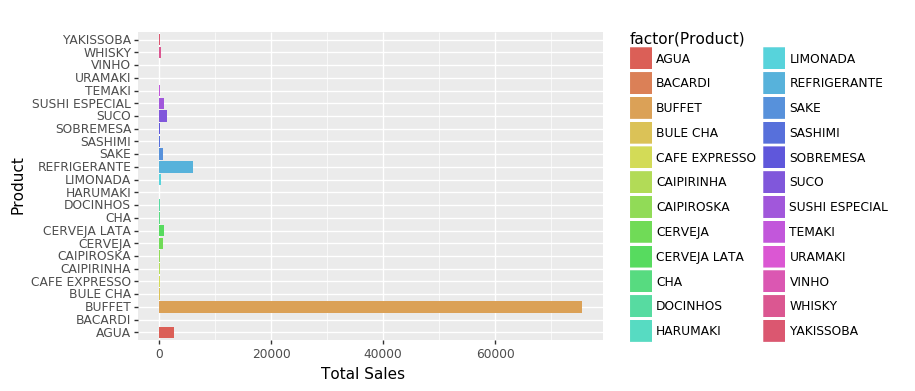

<ggplot: (8742068350757)>

In [61]:
ggplot(df_sells_group, aes(x='Product', y='value', fill='factor(Product)'))\
    + geom_bar(stat = "identity")\
    + labs(y="Total Sales", x = "Product")\
    + coord_flip()
    

From this plot we can see that the core product from the store is the Buffet, this make sense with the first chart, if it is a default self-service restaurant it is natural that the sells drop out on friday and saturday because on weekend people usually like to eat different kind of foods like hamburguers and other types of food.

So the core products are, in order: Buffet, Refrigerante and Agua

# Predicting sells

In this section I just want to do it fast, for this I will use the prophet lib, and from that I want to get a baseline for the last model. Prophet will give us a nice estimation for the next week sells but only for the final value, what is not so interesting for the store

In [156]:
#Instantiate the prophet lib and fit it with the data by days
pht = Prophet()
pht.fit(df_day)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 14.0.


In [157]:
#Create entrys for the next 7 days to use for the predict phase
future_dates = pht.make_future_dataframe(periods=7, freq='D')
future_dates.tail(8)

,ds
18,2016-01-23
19,2016-01-24
20,2016-01-25
21,2016-01-26
22,2016-01-27
23,2016-01-28
24,2016-01-29
25,2016-01-30


In [158]:
#Use the initial model to predict for the future dates
forecast = None
forecast = pht.predict(future_dates)

In [163]:
#Let's separete the predictions from the original DataFrame
df_preds = df_day
#creating a factor to discriminate the preds for plot
df_preds['is_pred'] = 0

#Filter the pred dataframe
df_pht = pd.DataFrame()
df_pht['ds'] = forecast.loc[forecast['ds'] > '2016-01-23']['ds']
df_pht['y'] = forecast.loc[forecast['ds'] > '2016-01-23']['yhat']
#creating a factor to discriminate the preds for plot
df_pht['is_pred'] = 1
df_preds = df_preds.append(df_pht)

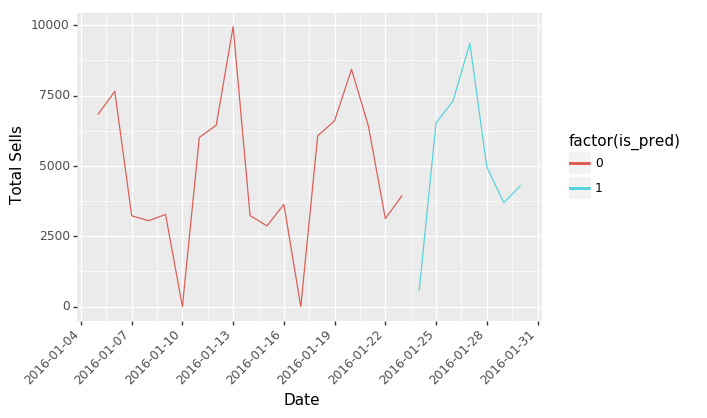

<ggplot: (8742068539897)>

In [164]:
ggplot(df_preds,aes('ds','y',color='factor(is_pred)'))\
    + geom_line()\
    + labs(y="Total Sells", x = "Date")\
    + theme(axis_text_x = element_text(angle = 45, hjust = 1))

In [165]:
#Preds of total sales on the next week
df_preds.loc[df_preds['is_pred'] == 1]['y'].sum()

36703.313221634511

### Next week sales forecast: 36.703 Reais

Using prophet to create our baseline give us a result of the total sales forecast for the next week.This would be enough for the challenge but it would not be very useful for the store. What I would like to do would be to create the forecast by product and by day to enable the store to carry out strategic planning (inventory, sales, product disposition) for the coming weeks.

-----

## Forecast by products

For this part I create predictions based on a very basic random forest model, without any kind of tunning to not overpass the 5 hour limit

In [68]:
## Reading data
all_data = json.load(open('sample.txt'))

In [69]:
## Creating main dataframe
df = pd.DataFrame()
## for each elem inside the full json get the data and put inside a dataframe
for elem in all_data:
    #Get date from each elem
    elem_date = elem['ide']['dhEmi']['$date']
    #Transform each order in a dataframe line
    for prods in elem['dets']:
        prod_name = prods['prod']['xProd']
        valor_produto = prods['prod']['vUnCom']
        #We will create a column with prodname_prodvalue 
        #because same prods exists with different prices, and we want it as a column
        prod_name = str(prod_name)+"_"+str(valor_produto)
        qtd_prod = prods['prod']['qCom'] 
        #Create data frame line
        one_line = pd.DataFrame(data = [[elem_date, qtd_prod]],
                                columns = ['date', prod_name])
        #Append to main dataframe
        df = df.append(one_line)


In [70]:
#Get list with all product names
list_products = list(df.drop(['date'], axis=1))

In [71]:
#Creating some features for future data analysis
df['date'] = pd.to_datetime(df['date'])
df = df.resample('H', on='date').sum().reset_index()
df['week_day'] = df.apply(lambda k: k['date'].weekday(), axis=1)
df['day_hour'] = df.apply(lambda k: k['date'].hour, axis=1)
df['weekend'] = df.apply(lambda k: 1 if k['week_day'] >= 5 else 0 , axis=1)

In [72]:
def get_day_period(hour):
    if hour < 12:
        return 0 #morning
    elif hour >= 12 and hour <= 17:
        return 1 #evening
    else:
        return 2 #night
    
df['day_period'] = df.apply(lambda k: get_day_period(k['date'].hour), axis=1)

These are the final features that were chosen by feature importance on the model and the effect on the final result. Other features which were used and removed are:
- Days since/to the weekend
- Business hour (9am to 18pm)
- Is_sunday feature

In [73]:
#Of course we have a lot of nans 
#because we created a sparse matrix using the products as columns
#We will fill that with zeros
df = df.fillna(0)

In [208]:
#Predicting
all_df_preds_days = pd.DataFrame()
total_valor_produto = []
df_prod_sales = pd.DataFrame()
for product in list_products:
    #We will make onde pred per product
    
    #Preparing the DataFrame
    df_prod = df[['date', 'week_day', 'day_hour',  'weekend',  'day_period', product]]
    df_prod = df_prod.rename(columns={product:'y', 'date': 'ds'})
    dates_train = df_prod['ds'].values
    #In this first time we will use prophet just for generate future dates
    pht = Prophet()
    pht.fit(df_prod)
    
    #Prepare the DataFrame for prediction per hour, 7 days = 24*7 h
    preds_prod_df = pht.make_future_dataframe(periods=168, freq='H')
    test_prod_df = pd.DataFrame()
    test_prod_df['ds'] = preds_prod_df.loc[preds_prod_df['ds'] > '2016-01-24']['ds']
    
    #Prepare the original df to simple predict
    df_prod = df_prod.drop('ds', axis=1)
    y_prod = df_prod['y']
    X_prod = df_prod.drop('y', axis=1)
    
    #Fit a very simple algorithm to create the preds
    clf = RandomForestRegressor(max_depth=10, random_state=0)
    clf.fit(X_prod, y_prod)
    
    #Preparing the test dataframe to generate preds
    test_prod_df['week_day'] = test_prod_df.apply(lambda k: k['ds'].weekday(), axis=1)
    test_prod_df['weekend'] = test_prod_df.apply(lambda k: 1 if k['week_day'] >= 5 else 0 , axis=1)
    test_prod_df['day_hour'] = test_prod_df.apply(lambda k: k['ds'].hour, axis=1)
    test_prod_df['day_period'] = test_prod_df.apply(lambda k: get_day_period(k['ds'].hour), axis=1)
    dates_test = test_prod_df['ds'].values
    test_prod_df = test_prod_df.drop(['ds'], axis=1)
    
    #Make predictions
    preds = clf.predict(test_prod_df)
    
    #Applying floor to the predict values
    pred_df = pd.DataFrame()
    #Theres no sense to sell '0.78' of water so I will put every product into a ceil
    # Only if the product is BUFFET that can be a fraction value I will keep it
    if 'BUFFET' in product:
        pred_df['preds'] = preds
    else:
        pred_df['preds'] = np.ceil(preds)
    
    #Group predictions by day
    pred_df['date'] = dates_test
    df_day_pred = pred_df.resample('D', on='date').sum().reset_index()
    
    #Sum up the dayly predictions
    qtd_diaria = df_day_pred['preds'].sum()
    
    #Append to final dataFrame
    df_day_pred['week_day'] = df_day_pred.apply(lambda k: k['date'].weekday(), axis=1)
    #Ensuring that predictions of sunday will be 0
    df_day_pred.loc[df_day_pred.week_day == 0, 'preds']= 0
    
    
    #Print results and putting into a dataframe
    preco_produto = float(product.split("_")[1])
    total_valor_produto.append(preco_produto * qtd_diaria)
    df_day_pred['total'] = df_day_pred['preds'] * preco_produto
    print ("Product {}, Price: {}, Qtd: {}, TOTAL: {}").format(product,
                                                              preco_produto,
                                                             qtd_diaria,
                                                             preco_produto* qtd_diaria)
    display(df_day_pred)
    all_df_preds_days = all_df_preds_days.append(df_day_pred)
    
    print" Predictions for {} ended!, Total Product sells: {}".format(product, qtd_diaria)
    
    ##append to df prod sales by product
    product_name_only = str(product.split("_")[0])
    qtd_product_sells = float(preco_produto* qtd_diaria)
    prod_sales = pd.DataFrame(columns=["Product","total"],
                              data=[[product_name_only,qtd_product_sells]])
    df_prod_sales = df_prod_sales.append(prod_sales)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Product AGUA_3.5, Price: 3.5, Qtd: 414.0, TOTAL: 1449.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,36.0,1,126.0
3,2016-01-27,252.0,2,882.0
4,2016-01-28,60.0,3,210.0
5,2016-01-29,24.0,4,84.0
6,2016-01-30,6.0,5,21.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for AGUA_3.5 ended!, Total Product sells: 414.0
Product AGUA_3.85, Price: 3.85, Qtd: 15.0, TOTAL: 57.75


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.00
1,2016-01-25,0.0,0,0.00
2,2016-01-26,0.0,1,0.00
3,2016-01-27,0.0,2,0.00
4,2016-01-28,0.0,3,0.00
5,2016-01-29,12.0,4,46.20
6,2016-01-30,3.0,5,11.55


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for AGUA_3.85 ended!, Total Product sells: 15.0
Product BACARDI_7.0, Price: 7.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for BACARDI_7.0 ended!, Total Product sells: 0.0
Product BUFFET_68.6, Price: 68.6, Qtd: 492.17624, TOTAL: 33763.290064


,date,preds,week_day,total
0,2016-01-24,15.41280,6,1057.318080
1,2016-01-25,0.00000,0,0.000000
2,2016-01-26,98.75640,1,6774.689040
3,2016-01-27,88.36608,2,6061.913088
4,2016-01-28,102.22680,3,7012.758480
5,2016-01-29,105.96080,4,7268.910880
6,2016-01-30,23.01816,5,1579.045776


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for BUFFET_68.6 ended!, Total Product sells: 492.17624
Product BULE CHA_8.2, Price: 8.2, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for BULE CHA_8.2 ended!, Total Product sells: 0.0
Product CAFE EXPRESSO_3.5, Price: 3.5, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CAFE EXPRESSO_3.5 ended!, Total Product sells: 0.0
Product CAIPIRINHA_12.0, Price: 12.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CAIPIRINHA_12.0 ended!, Total Product sells: 0.0
Product CAIPIROSKA_15.0, Price: 15.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CAIPIROSKA_15.0 ended!, Total Product sells: 0.0
Product CAIPIROSKA_18.0, Price: 18.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CAIPIROSKA_18.0 ended!, Total Product sells: 0.0
Product CERVEJA LATA_6.0, Price: 6.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA LATA_6.0 ended!, Total Product sells: 0.0
Product CERVEJA LATA_6.5, Price: 6.5, Qtd: 39.0, TOTAL: 253.5


,date,preds,week_day,total
0,2016-01-24,12.0,6,78.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,12.0,2,78.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,3.0,5,19.5


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA LATA_6.5 ended!, Total Product sells: 39.0
Product CERVEJA LATA_6.9, Price: 6.9, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA LATA_6.9 ended!, Total Product sells: 0.0
Product CERVEJA LATA_7.95, Price: 7.95, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA LATA_7.95 ended!, Total Product sells: 0.0
Product CERVEJA LATA_9.8, Price: 9.8, Qtd: 12.0, TOTAL: 117.6


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,12.0,3,117.6
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA LATA_9.8 ended!, Total Product sells: 12.0
Product CERVEJA_12.8, Price: 12.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_12.8 ended!, Total Product sells: 0.0
Product CERVEJA_18.0, Price: 18.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_18.0 ended!, Total Product sells: 0.0
Product CERVEJA_22.8, Price: 22.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_22.8 ended!, Total Product sells: 0.0
Product CERVEJA_4.5, Price: 4.5, Qtd: 60.0, TOTAL: 270.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,24.0,1,108.0
3,2016-01-27,12.0,2,54.0
4,2016-01-28,12.0,3,54.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_4.5 ended!, Total Product sells: 60.0
Product CERVEJA_4.95, Price: 4.95, Qtd: 27.0, TOTAL: 133.65


,date,preds,week_day,total
0,2016-01-24,12.0,6,59.40
1,2016-01-25,0.0,0,0.00
2,2016-01-26,0.0,1,0.00
3,2016-01-27,0.0,2,0.00
4,2016-01-28,0.0,3,0.00
5,2016-01-29,12.0,4,59.40
6,2016-01-30,3.0,5,14.85


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_4.95 ended!, Total Product sells: 27.0
Product CERVEJA_5.0, Price: 5.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_5.0 ended!, Total Product sells: 0.0
Product CERVEJA_5.5, Price: 5.5, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_5.5 ended!, Total Product sells: 0.0
Product CERVEJA_6.0, Price: 6.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_6.0 ended!, Total Product sells: 0.0
Product CERVEJA_7.0, Price: 7.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CERVEJA_7.0 ended!, Total Product sells: 0.0
Product CHA_1.0, Price: 1.0, Qtd: 147.0, TOTAL: 147.0


,date,preds,week_day,total
0,2016-01-24,12.0,6,12.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,60.0,1,60.0
3,2016-01-27,24.0,2,24.0
4,2016-01-28,12.0,3,12.0
5,2016-01-29,24.0,4,24.0
6,2016-01-30,3.0,5,3.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for CHA_1.0 ended!, Total Product sells: 147.0
Product DOCINHOS_3.2, Price: 3.2, Qtd: 48.0, TOTAL: 153.6


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,12.0,1,38.4
3,2016-01-27,12.0,2,38.4
4,2016-01-28,12.0,3,38.4
5,2016-01-29,12.0,4,38.4
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for DOCINHOS_3.2 ended!, Total Product sells: 48.0
Product HARUMAKI_6.8, Price: 6.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for HARUMAKI_6.8 ended!, Total Product sells: 0.0
Product HARUMAKI_7.2, Price: 7.2, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for HARUMAKI_7.2 ended!, Total Product sells: 0.0
Product LIMONADA_4.5, Price: 4.5, Qtd: 60.0, TOTAL: 270.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,12.0,1,54.0
3,2016-01-27,12.0,2,54.0
4,2016-01-28,12.0,3,54.0
5,2016-01-29,12.0,4,54.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for LIMONADA_4.5 ended!, Total Product sells: 60.0
Product LIMONADA_5.5, Price: 5.5, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for LIMONADA_5.5 ended!, Total Product sells: 0.0
Product REFRIGERANTE_4.5, Price: 4.5, Qtd: 675.0, TOTAL: 3037.5


,date,preds,week_day,total
0,2016-01-24,12.0,6,54.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,72.0,1,324.0
3,2016-01-27,336.0,2,1512.0
4,2016-01-28,96.0,3,432.0
5,2016-01-29,84.0,4,378.0
6,2016-01-30,15.0,5,67.5


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for REFRIGERANTE_4.5 ended!, Total Product sells: 675.0
Product REFRIGERANTE_4.95, Price: 4.95, Qtd: 54.0, TOTAL: 267.3


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,48.0,4,237.6
6,2016-01-30,6.0,5,29.7


 Predictions for REFRIGERANTE_4.95 ended!, Total Product sells: 54.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Product REFRIGERANTE_5.5, Price: 5.5, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


 Predictions for REFRIGERANTE_5.5 ended!, Total Product sells: 0.0

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Product REFRIGERANTE_6.8, Price: 6.8, Qtd: 12.0, TOTAL: 81.6


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,12.0,4,81.6
6,2016-01-30,0.0,5,0.0


 Predictions for REFRIGERANTE_6.8 ended!, Total Product sells: 12.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Product SAKE_15.0, Price: 15.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SAKE_15.0 ended!, Total Product sells: 0.0
Product SAKE_16.0, Price: 16.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SAKE_16.0 ended!, Total Product sells: 0.0
Product SAKE_20.9, Price: 20.9, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SAKE_20.9 ended!, Total Product sells: 0.0
Product SAKE_21.9, Price: 21.9, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SAKE_21.9 ended!, Total Product sells: 0.0
Product SAKE_38.4, Price: 38.4, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SAKE_38.4 ended!, Total Product sells: 0.0
Product SASHIMI_21.6, Price: 21.6, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SASHIMI_21.6 ended!, Total Product sells: 0.0
Product SOBREMESA_12.0, Price: 12.0, Qtd: 12.0, TOTAL: 144.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,12.0,2,144.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SOBREMESA_12.0 ended!, Total Product sells: 12.0
Product SOBREMESA_12.8, Price: 12.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SOBREMESA_12.8 ended!, Total Product sells: 0.0
Product SOBREMESA_6.0, Price: 6.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SOBREMESA_6.0 ended!, Total Product sells: 0.0
Product SOBREMESA_8.0, Price: 8.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


 Predictions for SOBREMESA_8.0 ended!, Total Product sells: 0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Product SUCO_4.5, Price: 4.5, Qtd: 213.0, TOTAL: 958.5


,date,preds,week_day,total
0,2016-01-24,12.0,6,54.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,24.0,1,108.0
3,2016-01-27,84.0,2,378.0
4,2016-01-28,36.0,3,162.0
5,2016-01-29,36.0,4,162.0
6,2016-01-30,9.0,5,40.5


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUCO_4.5 ended!, Total Product sells: 213.0
Product SUCO_4.9, Price: 4.9, Qtd: 12.0, TOTAL: 58.8


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUCO_4.9 ended!, Total Product sells: 12.0
Product SUCO_4.95, Price: 4.95, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUCO_4.95 ended!, Total Product sells: 0.0
Product SUCO_5.0, Price: 5.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUCO_5.0 ended!, Total Product sells: 0.0
Product SUCO_5.5, Price: 5.5, Qtd: 12.0, TOTAL: 66.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,12.0,4,66.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUCO_5.5 ended!, Total Product sells: 12.0
Product SUSHI ESPECIAL_18.0, Price: 18.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_18.0 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_21.6, Price: 21.6, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_21.6 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_23.8, Price: 23.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_23.8 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_25.6, Price: 25.6, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_25.6 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_295.0, Price: 295.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_295.0 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_6.5, Price: 6.5, Qtd: 27.0, TOTAL: 175.5


,date,preds,week_day,total
0,2016-01-24,12.0,6,78.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,12.0,4,78.0
6,2016-01-30,3.0,5,19.5


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_6.5 ended!, Total Product sells: 27.0
Product SUSHI ESPECIAL_7.0, Price: 7.0, Qtd: 75.0, TOTAL: 525.0


,date,preds,week_day,total
0,2016-01-24,12.0,6,84.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,12.0,1,84.0
3,2016-01-27,12.0,2,84.0
4,2016-01-28,12.0,3,84.0
5,2016-01-29,12.0,4,84.0
6,2016-01-30,3.0,5,21.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_7.0 ended!, Total Product sells: 75.0
Product SUSHI ESPECIAL_76.8, Price: 76.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_76.8 ended!, Total Product sells: 0.0
Product SUSHI ESPECIAL_9.8, Price: 9.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for SUSHI ESPECIAL_9.8 ended!, Total Product sells: 0.0
Product TEMAKI_12.0, Price: 12.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for TEMAKI_12.0 ended!, Total Product sells: 0.0
Product TEMAKI_14.4, Price: 14.4, Qtd: 12.0, TOTAL: 172.8


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,12.0,2,172.8
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for TEMAKI_14.4 ended!, Total Product sells: 12.0
Product URAMAKI_15.0, Price: 15.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for URAMAKI_15.0 ended!, Total Product sells: 0.0
Product VINHO_19.0, Price: 19.0, Qtd: 6.0, TOTAL: 114.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for VINHO_19.0 ended!, Total Product sells: 6.0
Product WHISKY_12.5, Price: 12.5, Qtd: 24.0, TOTAL: 300.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,12.0,1,150.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for WHISKY_12.5 ended!, Total Product sells: 24.0
Product WHISKY_15.0, Price: 15.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for WHISKY_15.0 ended!, Total Product sells: 0.0
Product WHISKY_16.0, Price: 16.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for WHISKY_16.0 ended!, Total Product sells: 0.0
Product WHISKY_16.8, Price: 16.8, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for WHISKY_16.8 ended!, Total Product sells: 0.0
Product WHISKY_22.9, Price: 22.9, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for WHISKY_22.9 ended!, Total Product sells: 0.0
Product YAKISSOBA_38.4, Price: 38.4, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for YAKISSOBA_38.4 ended!, Total Product sells: 0.0
Product YAKISSOBA_43.2, Price: 43.2, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


 Predictions for YAKISSOBA_43.2 ended!, Total Product sells: 0.0
Product YAKISSOBA_48.0, Price: 48.0, Qtd: 0.0, TOTAL: 0.0


,date,preds,week_day,total
0,2016-01-24,0.0,6,0.0
1,2016-01-25,0.0,0,0.0
2,2016-01-26,0.0,1,0.0
3,2016-01-27,0.0,2,0.0
4,2016-01-28,0.0,3,0.0
5,2016-01-29,0.0,4,0.0
6,2016-01-30,0.0,5,0.0


 Predictions for YAKISSOBA_48.0 ended!, Total Product sells: 0.0


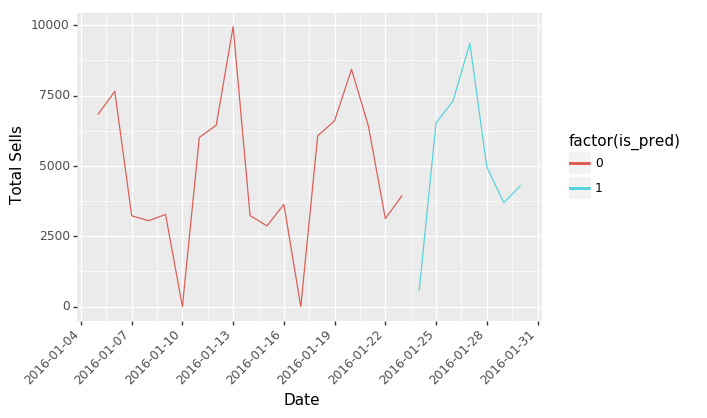

<ggplot: (8742068482109)>

In [210]:
week_preds = all_df_preds_days.resample('D', on='date').sum().reset_index()
preds = week_preds[['date', 'total']].rename(columns={'date':'ds', 'total':'y'})

#Tag the preds
preds['is_pred'] = 1
#Append to original values
preds = preds.append(df_day)

#Plot the data
ggplot(df_preds,aes('ds','y',color='factor(is_pred)'))\
    + geom_line()\
    + labs(y="Total Sells", x = "Date")\
    + theme(axis_text_x = element_text(angle = 45, hjust = 1))

In [209]:
week_preds['total'].sum()

37452.93534399999

### Next week sales forecast: 37.452 Reais

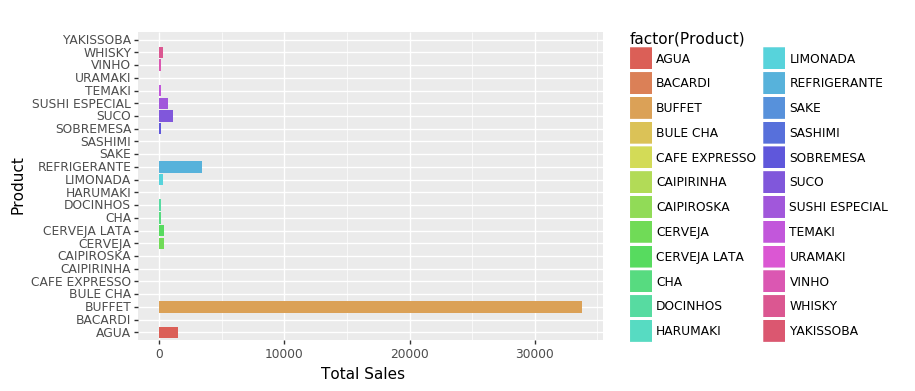

<ggplot: (8742067717329)>

In [217]:
#Groupping by and plot
df_prod_sales_group = df_prod_sales.groupby(['Product']).sum().reset_index().sort_values(by=['total'])
ggplot(df_prod_sales, aes(x='Product', y='total', fill='factor(Product)'))\
    + geom_bar(stat = "identity")\
    + labs(y="Total Sales", x = "Product")\
    + coord_flip()

The above chart give a forecast of total of sells by product in the next week. Also the two charts go well with the profile of the store viwed in the EDA phase, so I'm happy with my Predictions.

Future increases on performance can count on the tunning on the model and more data to augment our precision